In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.clustering import TimeSeriesKMeans

import acquire
import prepare
from env import get_db_url

import warnings
warnings.filterwarnings("ignore")


Go through the lesson commenting code, adding docstrings, and adding markdown to support what is happening.

In [2]:
# Acquire data from either SQL server or cached csv
df = acquire.acquire()
# Prepare data by downselecting columns, converting date to datetime format, changing index to date
df = prepare.prepare_curriculum(df)

In [3]:
# Not all cohort ids were filled in from the database source
df.isna().sum()

date             0
path             1
user_id          0
cohort_id    52893
ip               0
dtype: int64

Text(0, 0.5, 'Number of Entries')

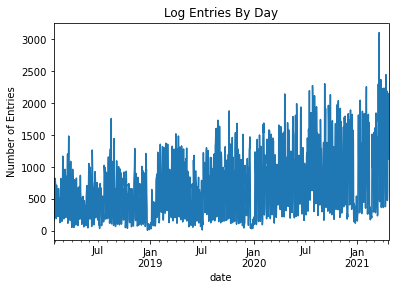

In [14]:
# Resample dataframe daily and take the total count of entries for that day. Save to pages
pages = df.path.resample('d').count()

# Plot entries by date
pages.plot()
plt.title('Log Entries By Day')
plt.ylabel('Number of Entries')

### Exponential Moving Average

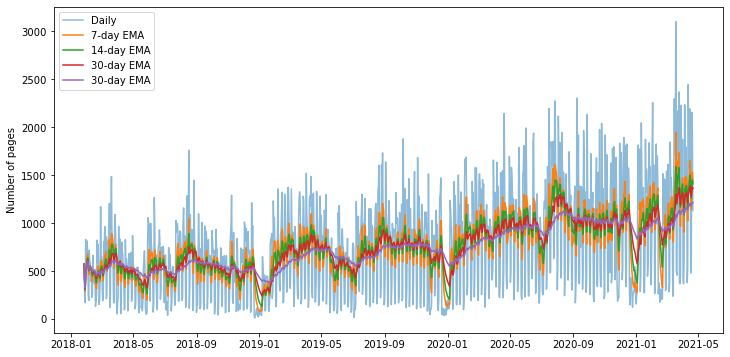

In [6]:
# Compute 7,14,30, and 90 day emas of counts of log entries

ema_7d = pages.ewm(span=7).mean()
ema_14d= pages.ewm(span=14).mean()
ema_30d= pages.ewm(span=30).mean()
ema_90d= pages.ewm(span=90).mean()

fig, ax = plt.subplots(figsize=(12,6))

# Plot count of entries (daily resample)
ax.plot(pages.index, pages, label='Daily', alpha=.5)
# Plot EMAs overlayed
ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()


Bollinger Bands

In [8]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()

# compute exponential stdev
stdev = pages.ewm(span=span).std()

# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3

# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)
bb.columns = ['ub', 'lb']

# Concatenate bb df onto pages df
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']

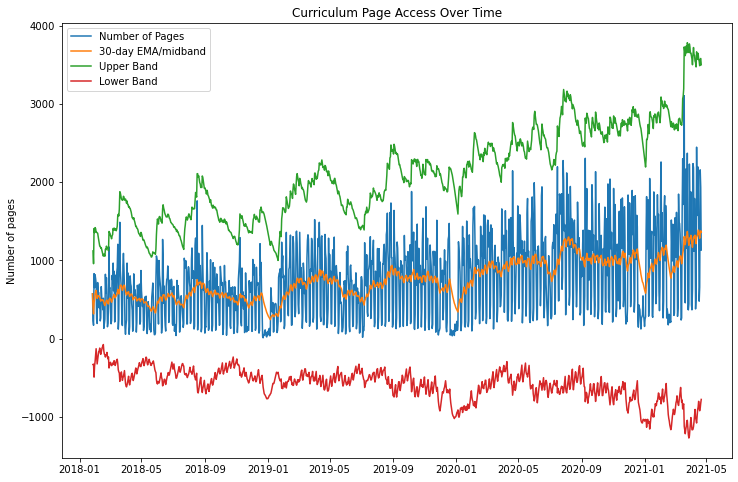

In [10]:
# Plot the Bollinger bands
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')
plt.title('Curriculum Page Access Over Time')
plt.show()


Calculate b% = $\frac{(last-LB)}{(UB-LB)}$
- Where does the point sit within range of upper to lower band?

In [12]:
# Calculate percent b for every value of pages
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

In [13]:
# Look for anomalies - those values above the upper band. This would mean %b is >1
my_df[my_df['pct_b']>1]

,pages,midband,ub,lb,pct_b
date,,,,,


### Set up anomaly detection by individual user

In [22]:
def prep(df, user):
    """ Prepare a df with records only from specific user """
    # Make a df with records only from specific user
    user_df = df[df.user_id == user]
    # Resample user_df by day
    pages = user_df.path.resample('d').count()
    return pages

In [23]:
def compute_pct_b(pages, span, weight, user):
    """ Compute the %b (Bollinger Band percentage) and output results as df """
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    """ Plot pages with Bollinger Bands """
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

def find_anomalies(df, user, span, weight):
    """ Identify anomalies, meaning %b is above 1. This equates to > weight*std above the EMA with length span"""
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
    # plt_bands(my_df, user)
    return my_df[my_df.pct_b>1]

Test functions on single user

In [39]:
user = 1
span = 30
weight = 6

anomalies = pd.DataFrame()
# Find anomalies for specific user based on pages, span, and weight
user_df = find_anomalies(df, user, span, weight)
# Concatenate anomalies df to the user's page views
anomalies = pd.concat([anomalies, user_df], axis=0)

In [40]:
anomalies

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,


No anomalies for user 1. Next will loop through all users.

In [41]:
span = 30
weight = 3.5

anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)


In [46]:
anomalies

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-01-29,44,3.623334,42.081344,-34.834677,1.024945,1
2019-07-08,101,8.248768,96.507472,-80.009936,1.025451,1
2018-10-15,9,0.581421,8.457414,-7.294571,1.034446,3
2019-01-09,4,0.262470,3.802115,-3.277175,1.027953,3
2019-04-06,2,0.129825,1.889712,-1.630061,1.031334,3
...,...,...,...,...,...,...
2021-01-24,7,0.574393,6.857226,-5.708440,1.011362,817
2021-03-25,59,6.824556,58.415342,-44.766230,1.005666,843
2021-02-23,67,8.229409,66.322904,-49.864086,1.005828,851


In [ ]:
# Take a look at the highest page views 
anomalies.pages.value_counts().sort_index(ascending=False)

272     1
198     1
192     1
179     1
165     1
       ..
5      58
4      76
3      71
2      36
1      48
Name: pages, Length: 99, dtype: int64

In [47]:
anomalies[anomalies.pages == 272]

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341


User 341 looks suspicious

In [48]:
df[df.user_id == 341]

,date,path,user_id,cohort_id,ip
date,,,,,
2019-01-22,2019-01-22,/,341,29.0,97.105.19.58
2019-01-22,2019-01-22,toc,341,29.0,97.105.19.58
2019-01-22,2019-01-22,html-css,341,29.0,97.105.19.58
2019-01-22,2019-01-22,html-css/introduction,341,29.0,97.105.19.58
2019-01-22,2019-01-22,html-css/elements,341,29.0,97.105.19.58
...,...,...,...,...,...
2021-02-09,2021-02-09,search/search_index.json,341,29.0,172.124.70.146
2021-02-09,2021-02-09,appendix/further-reading/spring/seeder,341,29.0,172.124.70.146
2021-02-10,2021-02-10,appendix/code-standards/mysql,341,29.0,172.124.70.146


This user is accessing the curriculum for over 2 years

## Bonus:

Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

Can you label students who are viewing both the web dev and data science curriculum? Can you label students by the program they are in? Can you label users by student vs. staff?

In [82]:
cohorts = df.groupby('cohort_id').resample('d').path.count().unstack()

<AxesSubplot:xlabel='date'>

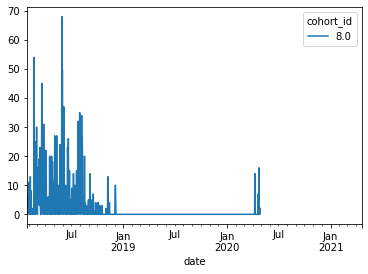

In [94]:
cohorts[cohorts.index == 8.0].T.plot()

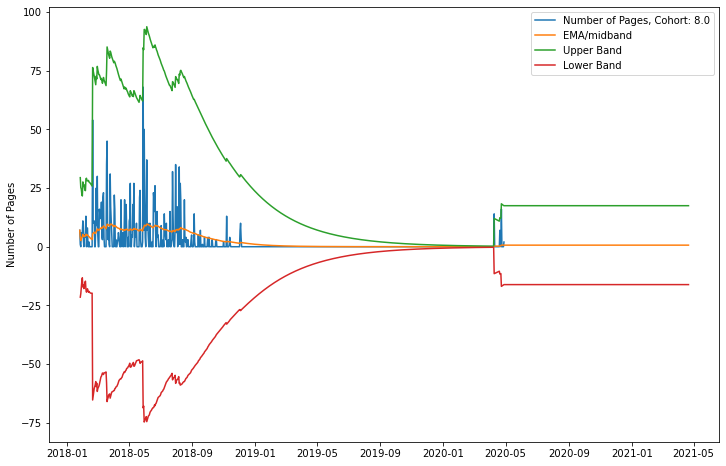

,pages,midband,ub,lb,pct_b,cohort
date,,,,,,
2020-04-09,14.0,0.277324,12.041189,-11.48654,1.083255,8.0


In [119]:
cohort = 8.0
span = 100
weight = 6
pages = cohorts[cohorts.index == cohort].T
midband = pages.ewm(span=span).mean()
stdev = pages.ewm(span=span).std()
ub = midband + stdev*weight
lb = midband - stdev*weight
bb = pd.concat([ub, lb], axis=1)
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
my_df['cohort'] = cohort


fig, ax = plt.subplots(figsize=(12,8))
ax.plot(my_df.index, my_df.pages, label='Number of Pages, Cohort: '+str(cohort))
ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
ax.legend(loc='best')
ax.set_ylabel('Number of Pages')
plt.show()

my_df[my_df.pct_b>1]

In [121]:
df[(df.index == '2020-04-09')&(df.cohort_id == 8.0)]

,date,path,user_id,cohort_id,ip
date,,,,,
2020-04-09,2020-04-09,/,646,8.0,173.174.197.146
2020-04-09,2020-04-09,content/html-css,646,8.0,173.174.197.146
2020-04-09,2020-04-09,content/html-css/gitbook/images/favicon.ico,646,8.0,173.174.197.146
2020-04-09,2020-04-09,content/html-css/introduction.html,646,8.0,173.174.197.146
2020-04-09,2020-04-09,content/html-css/elements.html,646,8.0,173.174.197.146
2020-04-09,2020-04-09,/,646,8.0,173.174.197.146
2020-04-09,2020-04-09,/,646,8.0,173.174.197.146
2020-04-09,2020-04-09,content/examples/html/gitbook/images/favicon.ico,646,8.0,173.174.197.146
2020-04-09,2020-04-09,content/examples/examples/html/gitbook/images/...,646,8.0,173.174.197.146


User 646 accessed the curriculum well after the end of his or her codeup time

In [122]:
df

,date,path,user_id,cohort_id,ip
date,,,,,
2018-01-26,2018-01-26,/,1,8.0,97.105.19.61
2018-01-26,2018-01-26,java-ii,1,8.0,97.105.19.61
2018-01-26,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...
2021-04-21,2021-04-21,jquery/personal-site,64,28.0,71.150.217.33
2021-04-21,2021-04-21,jquery/mapbox-api,64,28.0,71.150.217.33
2021-04-21,2021-04-21,jquery/ajax/weather-map,64,28.0,71.150.217.33


In [149]:
small_df = df.loc['01-2018']

In [150]:
small_df.cohort_id.nunique()

11

In [151]:
small_df.user_id.nunique()

79

<AxesSubplot:xlabel='date'>

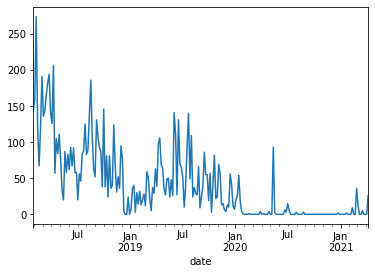

In [195]:
cohort_e = pd.DataFrame(df[df.cohort_id==14.0].resample('5d').path.count())

cohort_e.path.plot()